In [1]:
import pandas as pd
import os
import pickle
from math import log
from sklearn.mixture import GaussianMixture as GM
import numpy as np
from collections import Counter

### getting the file lists

In [2]:
# setting the data directory
data_dir = '../../AI_perception_survey_data/WE'
save_dir = '../../AI_perception_survey_data/WE/cleaned'

In [3]:
# getting all file names
all_files = os.listdir(data_dir)

In [4]:
all_files

['Public Perception of Artificial Intelligence Technologies [UK].csv',
 '.DS_Store',
 'Public Perception of Artificial Intelligence Technologies [Deutsche].csv',
 'cleaned',
 'Pollfish_Survey_%C3%96ffentliche_Wahrnehmung_der_k%C3%BCnstlichen_Intelligenz_%5BDeutsche%5D_1979903.xlsx',
 'Public Perception of Artificial Intelligence Technologies [intl_Ver].csv',
 "Perception Publique des technologies de l'Intelligence Artificielle [FR].csv",
 'Pollfish_Survey_Perception_Publique_des_technologies_de_l%27Intelligence_Artificielle_%5BFR%5D_1979900.xlsx']

In [5]:
# extracting the pollfish ones
pf_files = [file for file in all_files if file.split('_')[0] == 'Pollfish']

In [6]:
pf_files

['Pollfish_Survey_%C3%96ffentliche_Wahrnehmung_der_k%C3%BCnstlichen_Intelligenz_%5BDeutsche%5D_1979903.xlsx',
 'Pollfish_Survey_Perception_Publique_des_technologies_de_l%27Intelligence_Artificielle_%5BFR%5D_1979900.xlsx']

In [7]:
# loading all files in
pf_de = pd.read_excel(os.path.join(data_dir, pf_files[0]), sheet_name = 'Individuals')
pf_fr = pd.read_excel(os.path.join(data_dir, pf_files[1]), sheet_name = 'Individuals')

In [8]:
# taking a brief look
pf_fr.head()

,ID,Time Started,Time Finished,Manufacturer,OS,Country,Area,City,Provider,Gender,...,Gamer,Value Shopper,Food and Dining Lover,Entertainment Enthusiast,Fashionista,Job Seeker,Insurance,Real Estate,Car Purchase,Unnamed: 65
0,467934861,2019-05-17 08:12:35,2019-05-17 08:17:29,OnePlus,Android,FR,Brittany,Miniac-Morvan,Bouygues,male,...,True,True,True,True,False,NaN,NaN,NaN,NaN,NaN
1,-1953996334,2019-05-17 08:25:55,2019-05-17 08:27:54,Huawei,Android,FR,Île-de-France,Paris,Bouygues,male,...,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN
2,873807755,2019-05-17 08:16:32,2019-05-17 08:22:48,Unknown,Android,FR,Nouvelle-Aquitaine,Agen,SFR,male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1008838748,2019-05-17 08:22:18,2019-05-17 08:26:14,Unknown,Web,FR,Île-de-France,Paris,NaN,female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-920061686,2019-05-17 08:12:58,2019-05-17 08:14:22,Unknown,iOS,BE,Flanders,Ghent,NaN,male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have a lot of extra cols that might be interesting in other cases but for reason of uniformity we'll not need them for this analysis

### Taking a look at the time spend 

In [9]:
# converting the 2 cols to datetime format
pf_fr['Time Started'] = pd.to_datetime(pf_fr['Time Started'], format = "%Y-%m-%d %H:%M:%S")
pf_fr['Time Finished'] = pd.to_datetime(pf_fr['Time Finished'], format = "%Y-%m-%d %H:%M:%S")

pf_de['Time Started'] = pd.to_datetime(pf_de['Time Started'], format = "%Y-%m-%d %H:%M:%S")
pf_de['Time Finished'] = pd.to_datetime(pf_de['Time Finished'], format = "%Y-%m-%d %H:%M:%S")

In [10]:
# creating a new column recording the amount of time spent on the survey
pf_fr['time_spent'] = [(pf_fr['Time Finished'][i] - pf_fr['Time Started'][i]).seconds for i in range(len(pf_fr))]
pf_de['time_spent'] = [(pf_de['Time Finished'][i] - pf_de['Time Started'][i]).seconds for i in range(len(pf_de))]

In [11]:
# let's take a look at the hist FR
pf_fr.hist(column="time_spent", bins=20, figsize=(20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a164ca048>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1630d898>]],
      dtype=object)

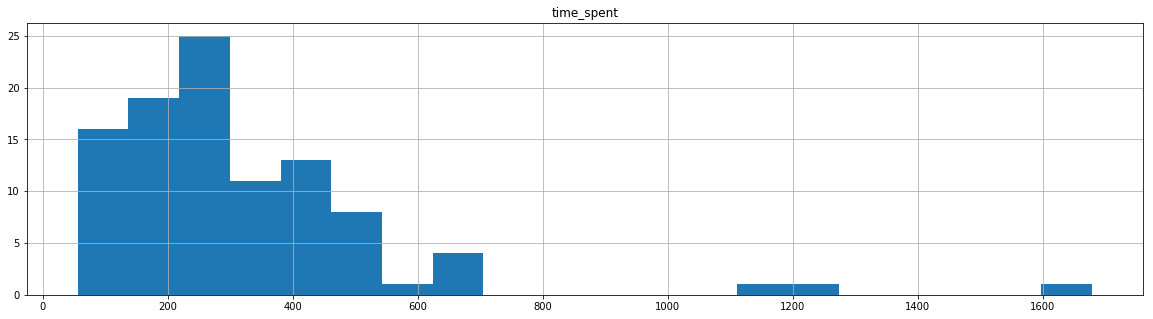

In [12]:
# let's take a look at the hist FR
pf_de.hist(column="time_spent", bins=20, figsize=(20, 5))

In [13]:
# we do a quick log transformation
pf_fr['time_spent_log'] = [log(time) for time in pf_fr['time_spent']]
pf_de['time_spent_log'] = [log(time) for time in pf_de['time_spent']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a16bcce80>]],
      dtype=object)

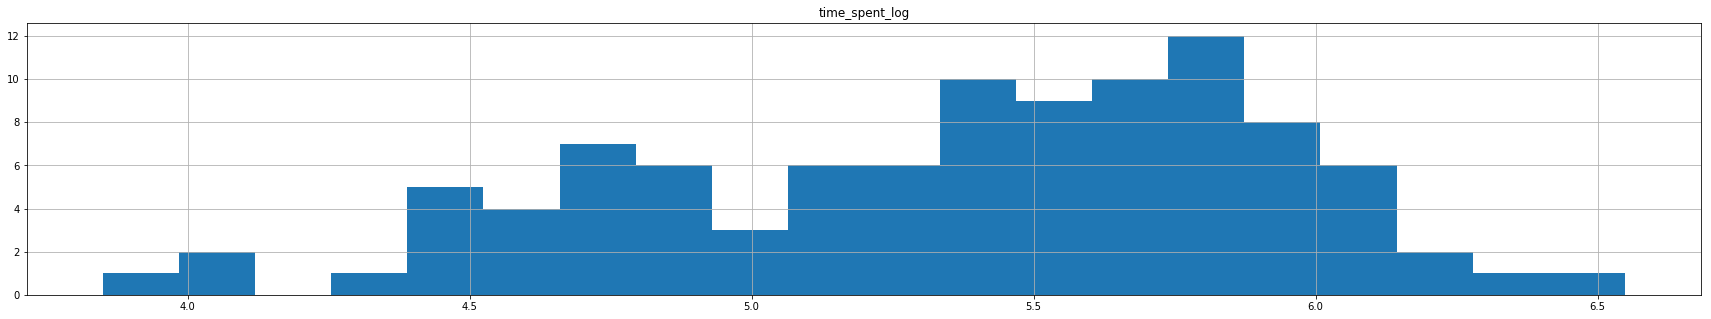

In [14]:
# and let's take a look again: histo FR
pf_fr.hist(column="time_spent_log", bins=20, figsize=(30, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1707b4e0>]],
      dtype=object)

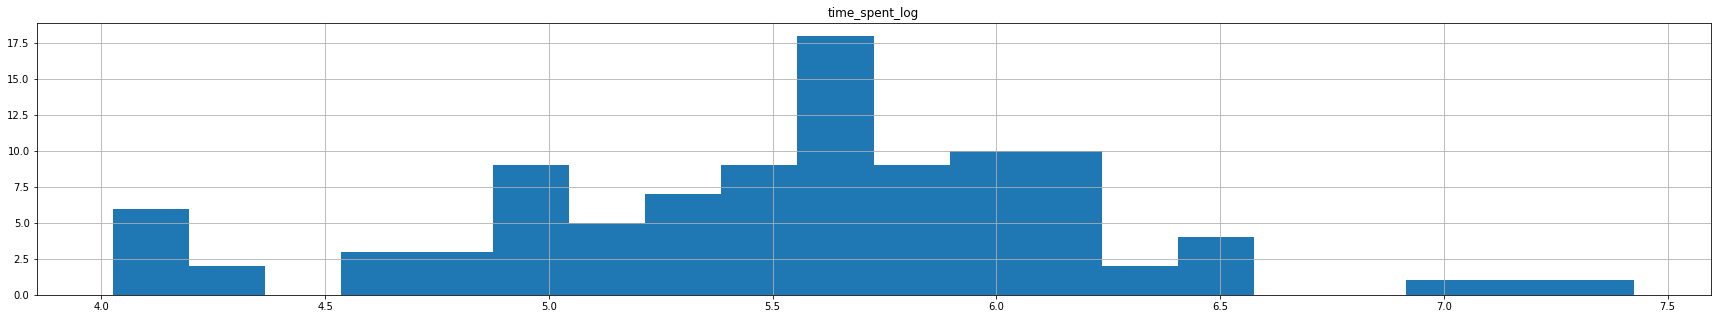

In [15]:
# and let's take a look again: histo DE
pf_de.hist(column="time_spent_log", bins=20, figsize=(30, 5))

While there is clear visual indication that the FR dataset can be modelled by a mixed Gaussian (2 peaks), the same cannot be said for the DE dataset. Going forward:

1. Run EM algo and classify on the FR dataset, remove cheaters
2. Determining the cut off point, cross check mannually with the DE dataset, then remove

In [16]:
# let's run a EM/Gaussian mixture on top to see what gives
gmm = GM(n_components = 2, max_iter=1000)
X_train = np.array(pf_fr.time_spent_log).reshape(len(pf_fr), 1)
gmm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [17]:
# let's take a look at the param vals
print('means:', gmm.means_)
print('variances:', gmm.covariances_)

means: [[5.69622868]
 [4.73230899]]
variances: [[[0.09647105]]

 [[0.13654184]]]


These are very similar to the CN dataset, damn people are universally annoying in the same ways across culture

In [18]:
# convert these into minutes
from math import exp
print('mean and var for main group')
print('{:.2f} minutes'.format(exp(5.69622868)/60))
print('{:.2f} minutes'.format(exp(0.09647105)/60))
print('mean and var for that other group')
print('{:.2f} minutes'.format(exp(4.73230899)/60))
print('{:.2f} minutes'.format(exp(0.13654184)/60))

mean and var for main group
4.96 minutes
0.02 minutes
mean and var for that other group
1.89 minutes
0.02 minutes


For comparison's sake, the CN dataset yielded these parameter values

mean and var for main group <br>
4.75 minutes <br>
0.03 minutes <br>
mean and var for that other group <br>
1.42 minutes <br>
0.02 minutes <br>

In [19]:
# create new col to store the classification label
pf_fr['g_num'] = gmm.predict(X_train)

In [20]:
# quick determination of which is which
np.mean(pf_fr[pf_fr.g_num == 1].time_spent)/60, np.mean(pf_fr[pf_fr.g_num == 0].time_spent)/60

(1.9063725490196077, 5.237626262626263)

OK so we need to remove group 1

In [21]:
Counter(pf_fr.g_num)

Counter({0: 66, 1: 34})

In [22]:
# let's compare the min max values of the two groups against the DE dataset

print(min(pf_fr[pf_fr.g_num == 1].time_spent), max(pf_fr[pf_fr.g_num == 1].time_spent))
print(min(pf_fr[pf_fr.g_num == 0].time_spent), max(pf_fr[pf_fr.g_num == 0].time_spent))
print(min(pf_de.time_spent), max(pf_de.time_spent))

47 171
175 698
56 1679


So going forward:
1. remove for FR dataset according to the classification results
2. remove for DE dataset based on the following critera: <br>

    if time_spent <= .5 * sum(171, 175):
           remove
    else:
        keep

In [23]:
# removing group 1
pf_fr = pf_fr[pf_fr.g_num == 0]

In [24]:
# removing for DE dataset
pf_de = pf_de[pf_de.time_spent > 173]

In [25]:
# let's see how many data points we have left
len(pf_fr), len(pf_de)

(66, 73)

We're good, now let's remove the added columns

In [26]:
pf_fr.drop(['time_spent', 'time_spent_log', 'g_num'], axis = 1, inplace = True)
pf_de.drop(['time_spent', 'time_spent_log'], axis = 1, inplace = True)

In [39]:
# resetting indices
pf_fr.reset_index(drop = True, inplace = True)
pf_de.reset_index(drop = True, inplace = True)

### cleaning, renaming and reordering columns

In [27]:
# seeing which cols to keep
for i, col in enumerate(pf_fr.columns):
    print('*******************', i, '*******************')
    print(col)
    print(' ')

******************* 0 *******************
ID
 
******************* 1 *******************
Time Started
 
******************* 2 *******************
Time Finished
 
******************* 3 *******************
Manufacturer
 
******************* 4 *******************
OS
 
******************* 5 *******************
Country
 
******************* 6 *******************
Area
 
******************* 7 *******************
City
 
******************* 8 *******************
Provider
 
******************* 9 *******************
Gender
 
******************* 10 *******************
Age
 
******************* 11 *******************
Year Of Birth
 
******************* 12 *******************
Comment évalueriez-vous votre connaissance personnelle des technologies d'intelligence artificielle ?
 
******************* 13 *******************
Parmi les affirmations suivantes, lesquelles sont * fausses * concernant la nature ou les capacités de l'intelligence artificielle ?
 
******************* 14 *******************
Avez

In [28]:
# selecting which cols to keep
cols_to_keep_fr = list(pf_fr.columns[12:37]) + [pf_fr.columns[5]] + [pf_fr.columns[10]] + [pf_fr.columns[39]]
cols_to_keep_de = list(pf_de.columns[12:37]) + [pf_de.columns[5]] + [pf_de.columns[10]] + [pf_fr.columns[39]]

In [29]:
# slimming the dfs down
pf_fr = pf_fr[cols_to_keep_fr]
pf_de = pf_de[cols_to_keep_de]

In [30]:
# new col names
cols_renamed = ['q{:02}'.format(i+1) for i in range(21)] + ['q{:02}'.format(i) for i in range(26,30)] + ['country_of_residence', 'q25_sup', 'q27_sup']

In [31]:
# renaming cols
pf_fr.columns = cols_renamed
pf_de.columns = cols_renamed

### recoding answers

In [32]:
pf_fr.head(3)

,q01,q02,q03,q04,q05,q06,q07,q08,q09,q10,...,q19,q20,q21,q26,q27,q28,q29,country_of_residence,q25_sup,q27_sup
0,J'en sais beaucoup sur le sujet,L’architecture du réseau neuronal récurrent ri...,Oui,5,6,5,7,5,7,Nouvelles opportunités commerciales | Meilleur...,...,Les compétences requises pour le travail sont ...,Oui,L'incapacité de l'IA à comprendre les nuances ...,Ingénieur métallurgique,Bachelor/BTS ou équivalent,Oui,6,FR,18 - 24,high_school
2,J'en ai entendu parler mais je ne suis pas sur...,L'IA n'est capable d'effectuer qu'une gamme li...,Peut-être,4,6,4,6,4,6,aucun,...,Manque de créativité,Peut-être,L'IA peut être biaisée et renforcer l'injustic...,Sans profession,Diplôme d'études secondaires ou l'équivalent,Oui,5,FR,45 - 54,vocational_technical_college
3,Je sais ce que c'est,L'IA peut se modifier et évoluer volontairemen...,Peut-être,4,3,6,7,4,5,Nouvelles opportunités commerciales | Meilleur...,...,Très répétitif,Peut-être,L'IA peut menacer l'humanité | L'incapacité de...,Etudiante en journalisme,Bachelor/BTS ou équivalent,Oui,4,FR,18 - 24,high_school


The seperators are '|', whereas our recoding function uses ';' as the default seperator, we need to replace

In [33]:
# noting question numbers that need recoding

# multiple choice
q_num_mc = [2,10,11,14,15,18,19,21,24]
q_num_mc = ['q{:02}'.format(num) for num in q_num_mc]
# single choice
q_num_sc = [1,3,16,17,20,22,23,25,27,28]
q_num_sc = ['q{:02}'.format(num) for num in q_num_sc]
# all
q_num_all = q_num_mc + q_num_sc

In [34]:
# replacing '|' with ';'
for q_num in q_num_mc:
    if q_num in pf_fr.columns:
        pf_fr[q_num] = [ans.replace(' | ', ';') for ans in pf_fr[q_num]]
        pf_de[q_num] = [ans.replace(' | ', ';') for ans in pf_de[q_num]]

### recoding

In [35]:
# importing the recoding function
from clean_functions import recode_answers

# regrouping the dataframes
all_pf = [pf_fr, pf_de]

In [36]:
# creating a list of lang variables
langs = ['fr', 'de']

# looping through all datasets
for i, dataset in enumerate(all_pf):
    # setting the right lang var
    lang = langs[i]
    
    # looping through all single choice questions
    for q_num in q_num_sc:
        # skipping questions that are missing
        if q_num in pf_fr.columns:
            # recode and replace
            dataset[q_num] = recode_answers(dataset, q_num, lang, False)
    
    # looping through all multiple choice questions
    for q_num in q_num_mc:
        # skipping questions that are missing
        if q_num in pf_fr.columns:
            # recode and replace
            dataset[q_num] = recode_answers(dataset, q_num, lang, True)

In [37]:
# inspecting the recoding results

cols = ['q{:02}'.format(i+1) for i in range(0,10)]
indices = list(range(30,60))

pf_fr.loc[indices, cols]

/Users/ruoyangzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


,q01,q02,q03,q04,q05,q06,q07,q08,q09,q10
30,C,"[I, L’IA peut rédiger des articles de qualité ...",B,6.0,7.0,5.0,6.0,4.0,7.0,"[C, B, A]"
31,C,"[G, D]",B,7.0,7.0,7.0,7.0,7.0,7.0,"[C, B, A]"
32,C,"[G, E, D]",C,4.0,4.0,3.0,5.0,4.0,4.0,"[B, A]"
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,D,"[I, G, D, B]",A,4.0,4.0,4.0,4.0,4.0,4.0,[B]
35,D,"[I, D, B]",A,6.0,7.0,7.0,6.0,7.0,6.0,"[C, A]"
36,B,"[E, A]",C,6.0,6.0,6.0,6.0,6.0,6.0,"[D, B, A]"
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,C,"[I, G, B]",C,5.0,6.0,3.0,6.0,4.0,5.0,"[D, C, A]"


Problems we've detected:
1. q02 --> one answer not properly coded

Clearly PF cut the end of the answer off probably due to its length, we mannually replace

In [45]:
# reecode by hand
to_recode_fr = {'L’IA peut rédiger des articles de qualité humaine avec un thème clair, une grammaire correcte et un': 'H'}
to_recode_de = {'KI bleibt ausschließlich in der akademischen Forschung und kann noch nicht kommerziell genutzt werde':'B',
'KI kann menschenähnlich Artikel mit einem klaren Thema mit korrekter Grammatik und fortgeschrittenem': 'H',
'Die Architektur eines Recurrent Neural Network wird wahrscheinlich weiterhin an Popularität verliere': 'I'}
pf_fr.q02 = [[to_recode_fr[an] if an in to_recode_fr.keys() else an for an in ans] for ans in pf_fr.q02]
pf_de.q02 = [[to_recode_de[an] if an in to_recode_de.keys() else an for an in ans] for ans in pf_de.q02]

In [49]:
max([len(ans) for ans in pf_fr.q02]), max([len(ans) for ans in pf_de.q02])

(8, 6)

### filling in empty columns and concat
let's take a look at the col names

In [50]:
pf_fr.columns

Index(['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'q08', 'q09', 'q10',
       'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20',
       'q21', 'q26', 'q27', 'q28', 'q29', 'country_of_residence', 'q25_sup',
       'q27_sup'],
      dtype='object')

In [51]:
pf_de.columns

Index(['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'q08', 'q09', 'q10',
       'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20',
       'q21', 'q26', 'q27', 'q28', 'q29', 'country_of_residence', 'q25_sup',
       'q27_sup'],
      dtype='object')

In [52]:
# the empty cols
to_placehold = [22,23,24,25]
placeholder_cols = ['q{:02}'.format(i) for i in to_placehold]

In [53]:
# create empty cols
for col in placeholder_cols:
    pf_fr[col] = ['' for _ in range(len(pf_fr))]
    pf_de[col] = ['' for _ in range(len(pf_de))]

Let's recode q27_sup to combine it with q27

In [54]:
# setting up recoding mechanism with a dict
q27_sup_opts = list(set(pf_de.q27_sup))

In [55]:
# recoding dict
recode_vars = ['A', 'E', 'B', 'C', 'A']
q27_sup_opts = {q27_sup_opts[i]:recode_vars[i] for i in range(len(q27_sup_opts))}

In [56]:
# recode fr
pf_fr.q27_sup = [q27_sup_opts[ans] if ans in q27_sup_opts.keys() else ans for ans in pf_fr.q27_sup]

In [57]:
# recode de
pf_de.q27_sup = [q27_sup_opts[ans] if ans in q27_sup_opts.keys() else ans for ans in pf_de.q27_sup]

Now let's see how q27 and q27_sup match up against each other

In [58]:
# comparing q27 & sup
match_q27_fr = [pf_fr.q27[i] == pf_fr.q27_sup[i] for i in range(len(pf_fr))]
match_q27_de = [pf_de.q27[i] == pf_de.q27_sup[i] for i in range(len(pf_fr))]

In [59]:
# percentage of perfect matching
sum(match_q27_fr)/len(match_q27_fr), sum(match_q27_de)/len(match_q27_de)

(0.12121212121212122, 0.3333333333333333)

In [60]:
# let's take a look at those who don't match
for i in range(len(pf_fr)):
    print('*******', i, '*******')
    print(pf_fr.q27[i])
    print(pf_fr.q27_sup[i])
    print(' ')

******* 0 *******
B
A
 
******* 1 *******
A
C
 
******* 2 *******
B
A
 
******* 3 *******
E
E
 
******* 4 *******
B
E
 
******* 5 *******
B
postgraduate
 
******* 6 *******
A
A
 
******* 7 *******
A
C
 
******* 8 *******
B
B
 
******* 9 *******
C
E
 
******* 10 *******
C
A
 
******* 11 *******
A
C
 
******* 12 *******
B
E
 
******* 13 *******
C
nan
 
******* 14 *******
A
C
 
******* 15 *******
D
A
 
******* 16 *******
A
nan
 
******* 17 *******
A
B
 
******* 18 *******
A
C
 
******* 19 *******
B
E
 
******* 20 *******
B
A
 
******* 21 *******
A
C
 
******* 22 *******
C
E
 
******* 23 *******
B
E
 
******* 24 *******
B
A
 
******* 25 *******
C
E
 
******* 26 *******
D
postgraduate
 
******* 27 *******
B
E
 
******* 28 *******
B
C
 
******* 29 *******
B
E
 
******* 30 *******
C
E
 
******* 31 *******
B
nan
 
******* 32 *******
C
nan
 
******* 33 *******
E
E
 
******* 34 *******
A
A
 
******* 35 *******
C
nan
 
******* 36 *******
A
nan
 
******* 37 *******
E
A
 
******* 38 *******
A
A
 
*

In [61]:
# let's take a look at those who don't match
for i in range(len(pf_de)):
    print('*******', i, '*******')
    print(pf_de.q27[i])
    print(pf_de.q27_sup[i])
    print(' ')

******* 0 *******
A
C
 
******* 1 *******
Realabschluss
C
 
******* 2 *******
A
A
 
******* 3 *******
realschule
B
 
******* 4 *******
A
A
 
******* 5 *******
A
A
 
******* 6 *******
A
A
 
******* 7 *******
A
A
 
******* 8 *******
Realschule
B
 
******* 9 *******
E
B
 
******* 10 *******
A
A
 
******* 11 *******
A
A
 
******* 12 *******
berufsausbildung
A
 
******* 13 *******
Hauptschule
C
 
******* 14 *******
A
A
 
******* 15 *******
C
E
 
******* 16 *******
A
A
 
******* 17 *******
E
E
 
******* 18 *******
A
A
 
******* 19 *******
Hauptschulabschluss
B
 
******* 20 *******
E
B
 
******* 21 *******
B
C
 
******* 22 *******
Mittlere Reife
B
 
******* 23 *******
A
A
 
******* 24 *******
Fachschule
B
 
******* 25 *******
A
A
 
******* 26 *******
C
E
 
******* 27 *******
E
E
 
******* 28 *******
Fachabitur
C
 
******* 29 *******
A
B
 
******* 30 *******
A
B
 
******* 31 *******
C
E
 
******* 32 *******
C
E
 
******* 33 *******
B
E
 
******* 34 *******
A
A
 
******* 35 *******
B
B
 
******

there is too much inconsistency, as a general rule of thumb, we're going to trust our data, and only use the sup data where necessary (custom answers and NaN)

In [62]:
# replacing answers for q27 where appropriate
possible_options = ["A", "B", "C", "D", "E"]
pf_fr.q27 = [ans if ans in possible_options else pf_fr.q27_sup[i] for i, ans in enumerate(pf_fr.q27)]
pf_de.q27 = [ans if ans in possible_options else pf_de.q27_sup[i] for i, ans in enumerate(pf_de.q27)]

### We need to recode the age group too

The categories do not exactly match ours, but they're similar enough, for the sake of the analysis we'll replace them with our categorisation. See the comparison below

             PF            GM
A-----------------[n/a]-----------------[<= 15]

B--------------[18 - 24]--------------[16 - 25]

C--------------[25 - 34]--------------[26 - 35]

D--------------[35 - 44]--------------[36 - 45]

E--------------[45 - 54]--------------[46 - 55]

F----------------[> 54]----------------[>= 56]


As indicated by the chart above, we can convert the data without much loss of accurate information

In [63]:
pf_age_brackets = sorted(list(set(pf_fr.q25_sup)))
pf_age_brackets

['18 - 24', '25 - 34', '35 - 44', '45 - 54', '> 54']

In [64]:
age_codes = ['B', 'C', 'D', 'E', 'F']

In [65]:
# creating recoding dict
age_dict_pf = {pf_age_brackets[i]:age_codes[i] for i in range(len(age_codes))}

In [66]:
# now converting the age column q24
pf_fr.q25 = [age_dict_pf[age] for age in pf_fr.q25_sup]
pf_de.q25 = [age_dict_pf[age] for age in pf_de.q25_sup]

In [67]:
# now we can drop the sup columns since we've encorporated them into the real qs
pf_fr.drop(['q25_sup', 'q27_sup'], axis = 1, inplace = True)
pf_de.drop(['q25_sup', 'q27_sup'], axis = 1, inplace = True)

In [68]:
# reordering the columns
pf_fr = pf_fr[sorted(pf_fr.columns)]
pf_de = pf_de[sorted(pf_fr.columns)]

### Concatenanting and exporting

In [69]:
pf_all = pd.concat([pf_fr, pf_de]).reset_index(drop = True)

In [71]:
pf_all.head()

,country_of_residence,q01,q02,q03,q04,q05,q06,q07,q08,q09,...,q20,q21,q22,q23,q24,q25,q26,q27,q28,q29
0,FR,D,"[I, G, F, E, D, C]",A,5,6,5,7,5,7,...,A,"[D, B, A]",,,,B,Ingénieur métallurgique,B,A,6
1,FR,B,"[D, B]",C,4,6,4,6,4,6,...,C,[C],,,,E,Sans profession,A,A,5
2,FR,C,"[G, B]",C,4,3,6,7,4,5,...,C,"[E, D, C, B, A]",,,,B,Etudiante en journalisme,B,A,4
3,FR,C,"[H, G, F, E, A]",C,5,6,5,6,4,6,...,C,"[D, C, B, A]",,,,E,Livreur produits fais.,E,A,5
4,FR,C,"[J, I, H]",C,5,5,6,7,3,3,...,C,"[D, B, A]",,,,D,Comptable,B,B,4


In [72]:
# we will choose to pickle this in order to preserve the list data type
with open(os.path.join(save_dir, 'pf_all.pickle'), 'wb') as handle:
    pickle.dump(pf_all, handle)


# we will also export this as a csv
pf_all.to_csv(os.path.join(save_dir, 'pf_all.csv'))